In [1]:
!pip install torchxrayvision matplotlib numpy pandas ipywidgets scikit-learn scikit-image seaborn

[TorchXRayVision: A library of chest X-ray datasets and models](https://arxiv.org/pdf/2111.00595)

https://github.com/naitik2314/Chest-X-Ray-Medical-Diagnosis-with-Deep-Learning

## Imports

In [2]:
# General utilities
import os
import sys
import platform
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import urllib.request
import tarfile
from concurrent.futures import ThreadPoolExecutor

# PyTorch and data handling
import torch, torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Image processing
import skimage
import skimage.transform

# Machine learning metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    balanced_accuracy_score,
    precision_recall_curve,
    auc,
)

# TorchXRayVision library
import torchxrayvision as xrv

In [3]:
num_workers = max(1, os.cpu_count() // 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

use_amp = True
scaler = torch.amp.GradScaler(enabled=use_amp)

In [4]:
batch_size = 128
num_samples = 1000
num_epochs = 10
unique_patients = True
pathology_masks = True

In [5]:
machine_name = platform.node()  
user = os.getenv("USER") or os.getenv("USERNAME") 
os_name = platform.system()  # Get os
print(f"Machine: {machine_name}")
print(f"OS: {os_name}")
print(f"User: {user}")

if machine_name == "Corsair" and os_name == "Linux" and user == "jon":
    os.makedirs(windows_drive / "images", exist_ok=True)
    os.makedirs(windows_drive / "checkpoints", exist_ok=True)
    os.makedirs(windows_drive / "papers", exist_ok=True)

    paths = {
        "images": windows_drive / "images",
        "checkpoints": windows_drive / "checkpoints",
        "papers": windows_drive / "papers",
    }

else:
    os.makedirs("dataset", exist_ok=True)
    os.makedirs("dataset/images", exist_ok=True)
    os.makedirs("dataset/images/images", exist_ok=True)
    os.makedirs("dataset/checkpoints", exist_ok=True)
    os.makedirs("dataset/papers", exist_ok=True)
    os.makedirs("dataset/models", exist_ok=True)

    paths = {
        "dataset": Path("dataset"),
        "tar_images": Path("dataset/images"),
        "images": Path("dataset/images/images"),
        "checkpoints": Path("dataset/checkpoints"),
        "papers": Path("dataset/papers"),
        "models": Path("dataset/models")
    }


Machine: jupyter-jalarssen
OS: Linux
User: jalarssen


## Paths

In [6]:
dir_tar_images = paths['tar_images']

path_dataset = paths['dataset']
path_images = paths['images']
path_csv_list = paths['dataset'] / "Data_Entry_2017.csv"
path_train_val_list = paths['dataset'] / "train_val_list.txt"
path_test_list = paths['dataset'] / "test_list.txt"
path_models = paths['models']
checkpoint_dir = paths['checkpoints']

## Classes

In [7]:
class ChestXRayDataset(Dataset):
    def __init__(self, file_list, image_dir, transform=None):
        self.file_list = file_list
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")  # Convert to RGB if needed

        if self.transform:
            image = self.transform(image)

        # Extract patient_id (optional)
        patient_id = img_name.split("_")[0]

        return {"img": image, "filename": img_name, "patient_id": patient_id}

## Functions

In [8]:
def download_file(link, folder, idx):
    """Downloads a file from a link to the specified folder."""
    file_name = f'images_{idx+1:03d}.tar.gz'
    file_path = os.path.join(folder, file_name)
    if os.path.exists(file_path):
        print(f"{file_name} already exists, skipping download.")
        return file_path
    try:
        print(f"Downloading {file_name}...")
        urllib.request.urlretrieve(link, file_path)
        print(f"{file_name} downloaded successfully.")
        return file_path
    except Exception as e:
        print(f"Failed to download {file_name}: {e}")
        return None

In [9]:
def extract_file(file_path, folder):
    """Extracts a .tar.gz file to the specified folder."""
    extracted_flag = file_path.replace('.tar.gz', '_extracted.flag')
    if os.path.exists(extracted_flag):
        print(f"{os.path.basename(file_path)} already extracted, skipping.")
        return
    try:
        print(f"Extracting {os.path.basename(file_path)}...")
        with tarfile.open(file_path, 'r:gz') as tar:
            tar.extractall(path=folder)
        with open(extracted_flag, 'w') as f:
            f.write('extracted')
        print(f"{os.path.basename(file_path)} extracted successfully.")
    except Exception as e:
        print(f"Failed to extract {os.path.basename(file_path)}: {e}")

In [10]:
def process_link(idx, link):
    """Handles downloading and extracting a single link."""
    file_path = download_file(link, dir_tar_images, idx)
    if file_path:
        extract_file(file_path, dir_tar_images)

In [11]:
def load_file_lists(train_val_path, test_path):
    """
    Load file lists from the provided paths.
    """
    with open(train_val_path, 'r') as f:
        train_val_files = [line.strip() for line in f.readlines()]
        
    with open(test_path, 'r') as f:
        test_files = [line.strip() for line in f.readlines()]
    
    return train_val_files, test_files

In [12]:
def split_dataset_by_file_list(dataset, train_val_files, test_files):
    """
    Split the dataset into train/validation and test sets based on file lists.
    
    Args:
        dataset: The full NIH_Dataset object.
        train_val_files: List of filenames for train/validation.
        test_files: List of filenames for test.
    
    Returns:
        train_val_dataset, test_dataset: Subsets of the original dataset.
    """
    # Create a mask for matching filenames
    train_val_mask = dataset.csv['Image Index'].isin(train_val_files)
    test_mask = dataset.csv['Image Index'].isin(test_files)

    # Get indices of matched files
    train_val_indices = dataset.csv[train_val_mask].index.tolist()
    test_indices = dataset.csv[test_mask].index.tolist()

    # Create dataset subsets
    train_val_dataset = Subset(dataset, train_val_indices)
    test_dataset = Subset(dataset, test_indices)

    return train_val_dataset, test_dataset

In [13]:
def load_checkpoint(checkpoint_path, model, optimizer, scaler):
    """
    Load the model, optimizer, and scaler states from a checkpoint file.

    Args:
        checkpoint_path (str): Path to the checkpoint file.
        model (torch.nn.Module): The model to load the state into.
        optimizer (torch.optim.Optimizer): The optimizer to load the state into.
        scaler (torch.cuda.amp.GradScaler): The gradient scaler to load the state into.

    Returns:
        int: The starting epoch to resume training.
        float: The loss at the checkpoint.
    """
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scaler.load_state_dict(checkpoint['scaler_state_dict'])
    start_epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Resuming from epoch {start_epoch}, loss: {loss:.4f}")
    return start_epoch, loss


In [14]:
def plot_samples_with_masks(samples, dataset, max_samples=4):
    """
    Plot multiple X-ray images side-by-side along with their semantic and pathology masks (if available).
    Only plots samples with available masks, up to `max_samples`.
    """
    count = 0
    for sample in samples:
        if "pathology_masks" in sample and sample["pathology_masks"]:
            width = len(sample["pathology_masks"])
            fig, axs = plt.subplots(1, max(2, 1 + width), sharey=True, figsize=(3 + 3 * width, 3))
            axs[0].imshow(sample["img"][0], cmap="Greys_r")
            axs[0].set_title(f"Index: {sample['idx']}")
            for i, patho in enumerate(sample["pathology_masks"].keys()):
                axs[i + 1].imshow(sample["img"][0], cmap="Greys_r")
                axs[i + 1].imshow(sample["pathology_masks"][patho][0] + 1, alpha=0.5)
                axs[i + 1].set_title(dataset.pathologies[patho])
            plt.show()
            count += 1

        elif "semantic_masks" in sample and sample["semantic_masks"]:
            width = len(sample["semantic_masks"])
            fig, axs = plt.subplots(1, max(2, 1 + width), sharey=True, figsize=(3 + 3 * width, 3))
            axs[0].imshow(sample["img"][0], cmap="Greys_r")
            axs[0].set_title(f"Index: {sample['idx']}")
            for i, patho in enumerate(sample["semantic_masks"].keys()):
                axs[i + 1].imshow(sample["img"][0], cmap="Greys_r")
                axs[i + 1].imshow(sample["semantic_masks"][patho][0] + 1, alpha=0.5)
                axs[i + 1].set_title(patho)
            plt.show()
            count += 1

        if count >= max_samples:  # Stop after plotting max_samples
            break

    if count == 0:
        print("No samples with masks found.")


## Download data

In [15]:
links = [
    'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
    'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
    'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
	'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
    'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',
	'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
	'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
    'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
	'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
	'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
	'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
	'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'
]

with ThreadPoolExecutor(max_workers=num_workers) as executor:
    executor.map(lambda args: process_link(*args), enumerate(links))

print("Download and extraction complete. Please check the extracted files.")

images_001.tar.gz already exists, skipping download.
images_002.tar.gz already exists, skipping download.
images_001.tar.gz already extracted, skipping.
images_003.tar.gz already exists, skipping download.
images_002.tar.gz already extracted, skipping.
images_003.tar.gz already extracted, skipping.
images_004.tar.gz already exists, skipping download.
images_004.tar.gz already extracted, skipping.
images_005.tar.gz already exists, skipping download.
images_006.tar.gz already exists, skipping download.
images_007.tar.gz already exists, skipping download.
images_007.tar.gz already extracted, skipping.
images_005.tar.gz already extracted, skipping.
images_006.tar.gz already extracted, skipping.
images_008.tar.gz already exists, skipping download.
images_009.tar.gz already exists, skipping download.
images_010.tar.gz already exists, skipping download.
images_011.tar.gz already exists, skipping download.
images_008.tar.gz already extracted, skipping.
images_009.tar.gz already extracted, skip

## Load data

In [16]:
transforms = transforms.Compose([
    xrv.datasets.XRayCenterCrop(),   # Crop the center of the image
    xrv.datasets.XRayResizer(224),  # Resize to 224x224
    # transforms.ToTensor(),          # Convert to tensor
    # transforms.Lambda(lambda x: x.unsqueeze(0) if x.dim() == 2 else x),  # Add channel dimension if missing
    # transforms.Lambda(lambda x: (x / 2048.0) * 1024.0)  # Normalize to [-1024, 1024]
])

In [17]:
dataset = xrv.datasets.NIH_Dataset(
    imgpath=path_images,
    csvpath=f"{path_dataset}/Data_Entry_2017_v2020.csv",
    transform=transforms,
    views=["PA", "AP"],
    unique_patients=unique_patients, # One image per patient
    pathology_masks=pathology_masks, # Load pathology masks
)
xrv.datasets.relabel_dataset(xrv.datasets.default_pathologies, dataset)

Lung Lesion doesn't exist. Adding nans instead.
Fracture doesn't exist. Adding nans instead.
Lung Opacity doesn't exist. Adding nans instead.
Enlarged Cardiomediastinum doesn't exist. Adding nans instead.


In [18]:
print(dataset)

{'Atelectasis': {0.0: 29140, 1.0: 1665},
 'Cardiomegaly': {0.0: 30028, 1.0: 777},
 'Consolidation': {0.0: 30369, 1.0: 436},
 'Edema': {0.0: 30727, 1.0: 78},
 'Effusion': {0.0: 29565, 1.0: 1240},
 'Emphysema': {0.0: 30539, 1.0: 266},
 'Enlarged Cardiomediastinum': {},
 'Fibrosis': {0.0: 30239, 1.0: 566},
 'Fracture': {},
 'Hernia': {0.0: 30724, 1.0: 81},
 'Infiltration': {0.0: 27354, 1.0: 3451},
 'Lung Lesion': {},
 'Lung Opacity': {},
 'Mass': {0.0: 29521, 1.0: 1284},
 'Nodule': {0.0: 29135, 1.0: 1670},
 'Pleural_Thickening': {0.0: 30051, 1.0: 754},
 'Pneumonia': {0.0: 30631, 1.0: 174},
 'Pneumothorax': {0.0: 30553, 1.0: 252}}
NIH_Dataset num_samples=30805 views=['PA', 'AP'] data_aug=None


In [19]:
train_val_files, test_files = load_file_lists(path_train_val_list, path_test_list)
train_val_dataset, test_dataset = split_dataset_by_file_list(dataset, train_val_files, test_files)

print(f"Train/Val Dataset: {len(train_val_dataset)} samples")
print(f"Test Dataset: {len(test_dataset)} samples")

Train/Val Dataset: 28008 samples
Test Dataset: 2797 samples


In [20]:
indices = list(range(num_samples))

train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)

train_dataset = Subset(train_val_dataset, train_indices)
val_dataset = Subset(train_val_dataset, val_indices)

print(f"Train Dataset: {len(train_dataset)} samples")
print(f"Validation Dataset: {len(val_dataset)} samples")

Train Dataset: 800 samples
Validation Dataset: 200 samples


In [21]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=num_workers
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=num_workers
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=num_workers
)

In [22]:
# for batch in train_loader:
#     images, labels = batch['img'], batch['lab']
#     print(f"Train batch: {images.shape}, {labels.shape}")
#     break

# for batch in val_loader:
#     images, labels = batch['img'], batch['lab']
#     print(f"Validation batch: {images.shape}, {labels.shape}")
#     break

# for batch in test_loader:
#     images, labels = batch['img'], batch['lab']
#     print(f"Test batch: {images.shape}, {labels.shape}")
#     break

## Load model

In [23]:
model = xrv.models.DenseNet(weights="nih").to(device)
model.op_threshs = None # Disable calibrated thresholds for the model

dict(zip(model.pathologies,xrv.datasets.default_pathologies))

{'Atelectasis': 'Atelectasis',
 'Consolidation': 'Consolidation',
 'Infiltration': 'Infiltration',
 'Pneumothorax': 'Pneumothorax',
 'Edema': 'Edema',
 'Emphysema': 'Emphysema',
 'Fibrosis': 'Fibrosis',
 'Effusion': 'Effusion',
 'Pneumonia': 'Pneumonia',
 'Pleural_Thickening': 'Pleural_Thickening',
 'Cardiomegaly': 'Cardiomegaly',
 'Nodule': 'Nodule',
 'Mass': 'Mass',
 'Hernia': 'Hernia',
 '': 'Enlarged Cardiomediastinum'}

In [24]:
# Align dataset pathologies to model pathologies
common_pathologies = list(set(dataset.pathologies) & set(model.pathologies))
num_common_pathologies = len(common_pathologies)
print(f"Common Pathologies: {common_pathologies}")

# Map dataset indices to model indices
dataset_to_model_indices = {dataset.pathologies.index(p): model.pathologies.index(p) for p in common_pathologies}
print(f"Dataset to Model Index Mapping: {dataset_to_model_indices}")

Common Pathologies: ['Cardiomegaly', 'Mass', 'Fibrosis', 'Edema', 'Atelectasis', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Pleural_Thickening', 'Effusion', 'Infiltration', 'Hernia', 'Emphysema', 'Nodule']
Dataset to Model Index Mapping: {10: 10, 12: 12, 6: 6, 4: 4, 0: 0, 8: 8, 3: 3, 1: 1, 9: 9, 7: 7, 2: 2, 13: 13, 5: 5, 11: 11}


In [25]:
# Determine the number of output features dynamically
dummy_input = torch.zeros(1, 1, 224, 224)  # Batch size 1, single channel, 224x224 input
if torch.cuda.is_available():
    dummy_input = dummy_input.cuda()

# Get the output shape of the feature extractor
with torch.no_grad():
    num_features = model.features(dummy_input).shape[1]  # The second dimension is the feature size

# Update the classifier to match the number of pathologies
model.classifier = torch.nn.Linear(num_features, num_common_pathologies).to(device)
print(f"Updated classifier to output {num_common_pathologies} pathologies.")


Updated classifier to output 14 pathologies.


In [26]:
# Update classifier to match the number of common pathologies
model.classifier = torch.nn.Linear(num_features, num_common_pathologies).to(device)
print(f"Updated classifier to output {num_common_pathologies} pathologies.")

Updated classifier to output 14 pathologies.


## Optimizers

In [27]:
optimizer = torch.optim.Adam(model.classifier.parameters()) # only train classifier

## Loss

In [28]:
criterion = torch.nn.BCEWithLogitsLoss().to(device)

## Training

In [29]:
num_epochs = 10
model_name = "first_model"
checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_{model_name}.pth")

# Load checkpoint if available
if os.path.exists(checkpoint_path):
    start_epoch, _ = load_checkpoint(checkpoint_path, model, optimizer, scaler)
else:
    start_epoch = 0  # Start from scratch if no checkpoint is found

Epoch 1 - Training Loss: 0.5544, Validation Loss: 0.3970 Checkpoint saved
Epoch 2 - Training Loss: 0.3223, Validation Loss: 0.2552 Checkpoint saved
Epoch 3 - Training Loss: 0.2083, Validation Loss: 0.1922 Checkpoint saved
Epoch 4 - Training Loss: 0.1626, Validation Loss: 0.1657 Checkpoint saved
Epoch 5 - Training Loss: 0.1414, Validation Loss: 0.1542 Checkpoint saved
Epoch 6 - Training Loss: 0.1299, Validation Loss: 0.1484 Checkpoint saved
Epoch 7 - Training Loss: 0.1259, Validation Loss: 0.1454 Checkpoint saved
Epoch 8 - Training Loss: 0.1186, Validation Loss: 0.1435 Checkpoint saved
Epoch 9 - Training Loss: 0.1242, Validation Loss: 0.1421 Checkpoint saved
Epoch 10 - Training Loss: 0.1168, Validation Loss: 0.1412 Checkpoint saved


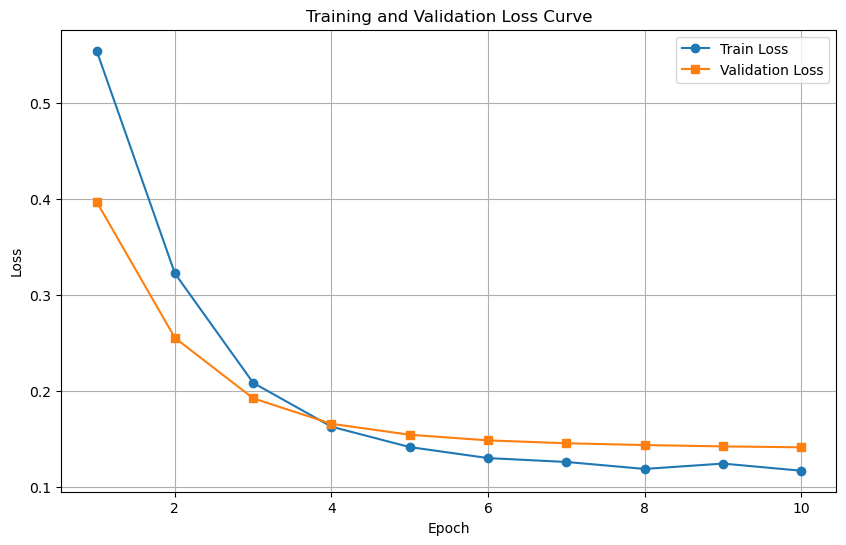

ValueError: No objects to concatenate

In [30]:
train_losses = []  # Store training losses for visualization
val_losses = []    # Store validation losses for visualization
all_results = []   # Store evaluation metrics

for epoch in range(start_epoch, num_epochs):
    # ========================
    # Training
    # ========================
    model.train()
    epoch_train_losses = []
    for i, batch in enumerate(train_loader):
        # Prepare data
        batch_tensors = {k: v.to(device, non_blocking=True) for k, v in batch.items() if isinstance(v, torch.Tensor)}
        optimizer.zero_grad()

        # Extract targets and align for the model
        dataset_indices = list(dataset_to_model_indices.keys())
        model_indices = list(dataset_to_model_indices.values())
        targets = batch_tensors["lab"][:, dataset_indices].float().to(device)
        targets_aligned = torch.zeros((targets.size(0), len(model.pathologies)), device=device, dtype=torch.float)
        targets_aligned[:, model_indices] = targets

        # Forward pass with mixed precision
        with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=use_amp):
            img_input = batch_tensors["img"].to(torch.float16)  # Convert to HalfTensor
            outputs = model(img_input)
            loss = criterion(outputs[:, model_indices], targets_aligned[:, model_indices])

        # Backward pass
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()

        # Log training loss
        epoch_train_losses.append(loss.item())

    # Store average training loss for this epoch
    avg_train_loss = np.mean(epoch_train_losses)
    train_losses.append(avg_train_loss)

    # ========================
    # Validation
    # ========================
    model.eval()
    epoch_val_losses = []
    with torch.no_grad():
        for batch in val_loader:
            # Prepare validation data
            batch_tensors = {k: v.to(device, non_blocking=True) for k, v in batch.items() if isinstance(v, torch.Tensor)}

            # Extract and align targets
            targets = batch_tensors["lab"][:, dataset_indices].float().to(device)
            targets_aligned = torch.zeros((targets.size(0), len(model.pathologies)), device=device, dtype=torch.float)
            targets_aligned[:, model_indices] = targets

            # Mixed precision for validation
            with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=use_amp):
                img_input = batch_tensors["img"]
                outputs = model(img_input)
                loss = criterion(outputs[:, model_indices], targets_aligned[:, model_indices])

            # Log validation loss
            epoch_val_losses.append(loss.item())

    # Store average validation loss for this epoch
    avg_val_loss = np.mean(epoch_val_losses)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1} - Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}", end=" ")

    # ========================
    # Log and Save Checkpoints
    # ========================
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch + 1}.pth")
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
    }, checkpoint_path)
    print("Checkpoint saved")

# ========================
# Loss Curve
# ========================
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid()
plt.show()

# ========================
# Final Results
# ========================
final_results = pd.concat(all_results, keys=range(1, num_epochs + 1))
final_results.to_csv(os.path.join(checkpoint_dir, "evaluation_results.csv"), index=False)